# Homework 1      
**Fatemeh Ahmadvand - s301384**

In [1]:
#pip install networkx
#pip install cvxpy

In [2]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms.flow import edmonds_karp
%matplotlib inline
import picos as pc
import cvxpy as cp
import scipy.io
import scipy

# Exercise 1
Consider the network in Figure 1 with link capacities
c2 = c4 = c6 = 1, c1 = c3 = c5 = 2.

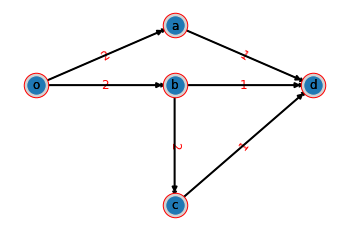

In [3]:
G = nx.DiGraph()
G.add_edges_from([("o","a"), ("o","b"), ("a","d"), ("b","d"), ("b","c"), ("c","d")])

# to find the maximal flow, the edges have to be labelled with a 'capacity' label
# we then modify the graph in such a way to include this information 
G["o"]["a"]['capacity'] = 2
G["o"]["b"]['capacity'] = 2
G["b"]["c"]['capacity'] = 2
G["a"]["d"]['capacity'] = 1
G["b"]["d"]['capacity'] = 1
G["c"]["d"]['capacity'] = 1
pos = {"o":[0,2], "a":[1,3], "b":[1,2], "c":[1,0], "d":[2,2]}

labels = nx.get_edge_attributes(G, 'capacity')

nx.draw_networkx_edge_labels(G,pos,edge_labels=labels, font_size=12, font_color='red')

nx.draw(G, pos, node_size = 600, font_size=12, node_color='lightgray', with_labels=True, width=2,
        edge_color = 'black', edgecolors='red')

plt.savefig("plot2.1.svg", format="svg")

nx.draw(G, pos, with_labels = True)

**(a)** What is the minimum aggregate capacity that needs to be removed for no feasible flow from o to d to exist?

**Solution**: first compute the possible path o-d:

-----------Path------------|----flow----|----Min Cut----|

Path 1: o -> a -> d......|.......1.......|.....{a,d}

Path 2: o -> b -> d......|.......1.......|.....{b,d}

Path 3: o-> b-> c->d...|.......1.......|.....{c,d}

In [4]:
nx.algorithms.flow.minimum_cut(G,"o","d")

(3, ({'a', 'b', 'c', 'o'}, {'d'}))

In [5]:
cut_value, partition = nx.algorithms.flow.minimum_cut(G,"o","d")
print("cut_value:",cut_value)  # Value of the minimum cut
print("partition:",partition)  #‘partition’ here is a tuple with the two sets of nodes that define the minimum cut

cut_value: 3
partition: ({'b', 'o', 'c', 'a'}, {'d'})


**(b)** What is the maximum aggregate capacity that can be removed from the links without 
affecting the maximum throughput from o to d?

In [6]:
nx.algorithms.flow.maximum_flow(G,"o","d")

# maximum_flow returns the maximal throughput, plus a dictionary containing the value of the flow that goes through each edge.

(3,
 {'o': {'a': 1, 'b': 2},
  'a': {'d': 1},
  'b': {'d': 1, 'c': 1},
  'd': {},
  'c': {'d': 1}})

maximum_flow returns both the value of the maximum flow and a dictionary with all flows.

As expected, the minimum cut equals the maximal flow.

**c)** You are given x > 0 extra units of capacity. How should you distribute them in order to
maximize the throughput that can be sent from o to d? Plot the maximum throughput from o to d as a function of x ≥ 0.

In [7]:
import picos as pc

for x in range(0, 10):
  # Extra capacity available
  gamma = x

  # Extracting capacities as dictionary
  c = {}
  for e in sorted(G.edges(data=True)):
    capacity = e[2]['capacity']
    c[(e[0], e[1])]  = capacity

  # Convert the capacities to a PICOS expression.
  cc = pc.new_param('c',c)

  s, t = 'o', 'd'

  maxflow=pc.Problem()

  # Add the flow variables.
  f={}
  for e in G.edges():
    f[e]=maxflow.add_variable('f[{0}]'.format(e))

  # Add the extra capacity variable
  ex={}
  for e in G.edges():
    ex[e]=maxflow.add_variable('ex[{0}]'.format(e))

  # Add the objective variable for the total flow.
  F=maxflow.add_variable('F')

  # CONSTRAINTS
  # Enforce flow conservation.
  maxflow.add_list_of_constraints([
      pc.sum([f[p,i] for p in G.predecessors(i)])
      == pc.sum([f[i,j] for j in G.successors(i)])
      for i in G.nodes() if i not in (s,t)])

  # Set source flow at s.
  maxflow.add_constraint(
    pc.sum([f[p,s] for p in G.predecessors(s)]) + F
    == pc.sum([f[s,j] for j in G.successors(s)]))

  # Set sink flow at t.
  maxflow.add_constraint(
    pc.sum([f[p,t] for p in G.predecessors(t)])
    == pc.sum([f[t,j] for j in G.successors(t)]) + F)

  # Enforce flow nonnegativity.
  maxflow.add_list_of_constraints([f[e] >= 0 for e in G.edges()])

  # Enforce edge capacities.
  maxflow.add_list_of_constraints([f[e] <= cc[e] + ex[e] for e in G.edges()])

  # Enforce extra capacity nonnegativity.
  maxflow.add_list_of_constraints([ex[e] >= 0 for e in G.edges()])

  # Set extra capacity value constraint.
  maxflow.add_constraint(pc.sum([ex[e] for e in G.edges()]) <= gamma)

  # Set the objective.
  maxflow.set_objective('max', F)

  # Solve the problem.
  maxflow.solve(solver='glpk')

c:\users\sadaf\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: new_param is deprecated: Use picos.Constant instead.
  
c:\users\sadaf\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:23: DeprecationWarning: Problem.add_variable is deprecated: Variables can now be created independent of problems, and do not need to be added to any problem explicitly.
c:\users\sadaf\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:28: DeprecationWarning: Problem.add_variable is deprecated: Variables can now be created independent of problems, and do not need to be added to any problem explicitly.
c:\users\sadaf\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:31: DeprecationWarning: Problem.add_variable is deprecated: Variables can now be created independent of problems, and do not need to be added to any problem explicitly.


In [8]:
import math
import random

print(math.floor(F))

for val in ex.items():
  print(val[0], round(val[1]))

8
('o', 'a') 4
('o', 'b') 0
('a', 'd') 5
('b', 'd') 0
('b', 'c') 0
('c', 'd') 0


# Exercise 2

**Definition**: given a graph $G=(V,E)$, a matching is a subset of edges $M \subseteq E$ such that no two edges in $M$ share a common node (head or tail).

**Definition**: Consider a simple bipartite graph, whereby the node set can be partitioned as $V = V_0 \cup V_1$, with $V_0 \cap V_1 = \emptyset$, and no edges between nodes of the same set exist. For $h = 0,1$, we shall refer to a matching $M$ in $G$ as $V_h$-perfect (or $V_h$-saturating) if every node in $V_h$ is matched in $M$.

There are a set of people {p1, p2, p3, p4} and a set of books {b1, b2, b3, b4}. Each
person is interested in a subset of books, specifically
p1 → {b1, b2}, p2 → {b2, b3}, p3 → {b1, b4}, p4 → {b1, b2, b4}

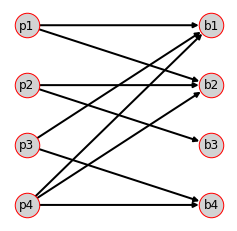

In [9]:
#G bipartite graph
G = nx.DiGraph()
G.add_edges_from([("p1","b1"), ("p1","b2"), ("p2","b2"), ("p2","b3"), ("p3","b1"), ("p3","b4"),
                  ("p4","b1"), ("p4","b2"), ("p4","b4")])

#Draw the Bipartite Graph
fig, ax = plt.subplots(figsize=(4,4))

pos = {"p1":[0,2], "p2":[0,1], "p3":[0,0], "p4":[0,-1], "b1":[1,2], "b2":[1,1], "b3":[1,0], "b4":[1,-1]}
nx.draw(G, pos, node_size = 600, font_size=12, node_color='lightgray', with_labels=True, width=2,
        edge_color = 'black', edgecolors='red', ax=ax)

plt.savefig("plot2.1.svg", format="svg")

**(a)** Exploit max-flow problems to find a perfect matching (if any).

Max flow:  (4, {'p1': {'b1': 0, 'b2': 1}, 'b1': {'d': 1}, 'b2': {'d': 1}, 'p2': {'b2': 0, 'b3': 1}, 'b3': {'d': 1}, 'p3': {'b1': 1, 'b4': 0}, 'b4': {'d': 1}, 'p4': {'b1': 0, 'b2': 0, 'b4': 1}, 's': {'p1': 1, 'p2': 1, 'p3': 1, 'p4': 1}, 'd': {}})


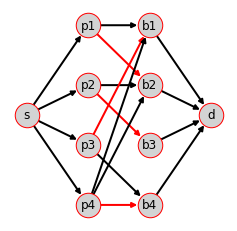

In [10]:
# add source and destionation to bipartite graph
dG = nx.DiGraph()
dG.add_edges_from([("p1","b1"), ("p1","b2"), ("p2","b2"), ("p2","b3"), ("p3","b1"), ("p3","b4"),
                   ("p4","b1"), ("p4","b2"), ("p4","b4")])
dG.add_edges_from([("s","p1"), ("s","p2"), ("s","p3"), ("s","p4"), ("b1","d"), ("b2", "d"),
                   ("b3","d"), ("b4","d")])
# unitary capacity
dG["p1"]["b1"]['capacity']=1
dG["p1"]["b2"]['capacity']=1
dG["p2"]["b2"]['capacity']=1
dG["p2"]["b3"]['capacity']=1
dG["p3"]["b1"]['capacity']=1
dG["p3"]["b4"]['capacity']=1
dG["p4"]["b1"]['capacity']=1
dG["p4"]["b2"]['capacity']=1
dG["p4"]["b4"]['capacity']=1
dG["s"]["p1"]['capacity']=1
dG["s"]["p2"]['capacity']=1
dG["s"]["p3"]['capacity']=1
dG["s"]["p4"]['capacity']=1
dG["b1"]["d"]['capacity']=1
dG["b2"]["d"]['capacity']=1
dG["b3"]["d"]['capacity']=1
dG["b4"]["d"]['capacity']=1
# Max-flow of Graph
print("Max flow: ", nx.algorithms.flow.maximum_flow(dG, "s", "d"))
# draw graph
fig, ax = plt.subplots(figsize=(4,4))

edge_colors = ["black","red","black","black","black","red","black","red","black","black","black",
               "black","red","black","black","black","black"]
pos = {"p1":[0,2], "p2":[0,1], "p3":[0,0], "p4":[0,-1], "b1":[1,2], "b2":[1,1], "b3":[1,0], 
       "b4":[1,-1], "s":[-1,0.5], "d":[2,0.5]}
nx.draw(dG, pos, node_size = 600, font_size=12, node_color='lightgray', with_labels=True, width=2,
        edge_color = edge_colors, edgecolors='red', ax=ax)
plt.savefig("plot2.2.svg", format="svg")

**(b)** Assume now that there are multiple copies books, and the distribution of the number of
copies is (2, 3, 2, 2). Each person can take an arbitrary number of different books. Exploit
the analogy with max-flow problems to establish how many books of interest can be assigned
in total.


Max flow:  (8, {'p1': {'b1': 1, 'b2': 1}, 'b1': {'d': 2}, 'b2': {'d': 3}, 'p2': {'b2': 1, 'b3': 1}, 'b3': {'d': 1}, 'p3': {'b1': 1, 'b4': 1}, 'b4': {'d': 2}, 'p4': {'b1': 0, 'b2': 1, 'b4': 1}, 's': {'p1': 2, 'p2': 2, 'p3': 2, 'p4': 2}, 'd': {}})


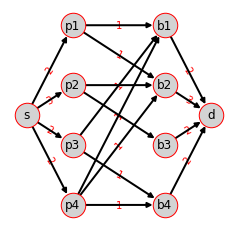

In [11]:
# weighted bipartite graph
G_weighted = nx.DiGraph()
G_weighted.add_edges_from([("p1","b1"), ("p1","b2"), ("p2","b2"), ("p2","b3"), ("p3","b1"), ("p3","b4"),
                           ("p4","b1"), ("p4","b2"), ("p4","b4")])
G_weighted.add_edges_from([("s","p1"), ("s","p2"), ("s","p3"), ("s","p4"), ("b1","d"), ("b2", "d"),("b3","d"), ("b4","d")])
# weighted capacity
G_weighted["p1"]["b1"]['capacity']=1
G_weighted["p1"]["b2"]['capacity']=1
G_weighted["p2"]["b2"]['capacity']=1
G_weighted["p2"]["b3"]['capacity']=1
G_weighted["p3"]["b1"]['capacity']=1
G_weighted["p3"]["b4"]['capacity']=1
G_weighted["p4"]["b1"]['capacity']=1
G_weighted["p4"]["b2"]['capacity']=1
G_weighted["p4"]["b4"]['capacity']=1
G_weighted["s"]["p1"]['capacity']=2
G_weighted["s"]["p2"]['capacity']=3
G_weighted["s"]["p3"]['capacity']=2
G_weighted["s"]["p4"]['capacity']=2
G_weighted["b1"]["d"]['capacity']=2
G_weighted["b2"]["d"]['capacity']=3
G_weighted["b3"]["d"]['capacity']=2
G_weighted["b4"]["d"]['capacity']=2
# Max-flow of Graph
print("Max flow: ", nx.algorithms.flow.maximum_flow(G_weighted,"s","d"))
# draw Graph
fig, ax = plt.subplots(figsize=(4,4))
edge_colors = ["black","black","black","black","black","black","black","black","black","black","black",
               "black","black","black","black","black","black"]
pos = {"p1":[0,2], "p2":[0,1], "p3":[0,0], "p4":[0,-1], "b1":[2,2], "b2":[2,1], "b3":[2,0], "b4":[2,-1],
       "s":[-1,0.5], "d":[3,0.5]}
labels = nx.get_edge_attributes(G_weighted, 'capacity')
nx.draw_networkx_edge_labels(G_weighted,pos,edge_labels=labels, font_size=10, font_color='red')
nx.draw(dG, pos, node_size = 600, font_size=12, node_color='lightgray', with_labels=True, width=2, 
        edge_color = edge_colors, edgecolors='red', ax=ax)
plt.savefig("plot2.3.svg", format="svg")

(c) Suppose that the library can sell a copy of a book and buy a copy of another book. Which
books should be sold and bought to maximize the number of assigned books?

In [12]:
nodes = G_weighted.nodes  #store nodes
edges = G_weighted.edges  #store edges

for node_i in nodes:

    inflow = 0                  #no of input edge
    outflow = 0                 #no of output edge
    maxPossibleOutflow = 0      

    # source node is not considered
    if node_i == "s": continue

    # person nodes is not considered
    if node_i == "p1": continue
    if node_i == "p2": continue
    if node_i == "p3": continue
    if node_i == "p4": continue

    # inflow of destination node is the maximal possible flow of graph  محاسبه مجموع وزنهای ورودی به نود پایانی
    if node_i == "d":
         for u, v, data in G_weighted.in_edges(node_i, data=True):  # data = true-->
            #print ("data.values:",data.values())
            maxPossibleOutflow = sum(data.values()) + maxPossibleOutflow
            #print("maxPossibleOutflow:", maxPossibleOutflow)
            
            
    # calculate inflow of node_i (Book nodes)
    for u, v, data in G_weighted.in_edges(node_i, data=True):
        inflow = sum(data.values()) + inflow
    print(node_i , "inflow:", inflow)
        
    # calculate outflow of node_i (Book nodes)
    for u, v, data in G_weighted.out_edges(node_i, data=True):
        outflow = sum(data.values()) + outflow
    print(node_i , "outflow:", outflow)
        
    # netflow of node_i (Book nodes)
    netflow = inflow - outflow

    # if some nodes has inflow greater or minor than outflow means that it has not an optimized flow
    # if some nodes has 
    if netflow >0 and node_i != "s" and node_i != "d":
        print(f"{netflow} copy of the book {node_i} can be sold ")
    if netflow <0 and node_i != "s" and node_i != "d":
        print(f"{-netflow} copy of the book {node_i} can be bought ")
       #print(f"Node {node_i} not optimized, netflow is {netflow}")

print("Max possible outflow: ", maxPossibleOutflow)

b1 inflow: 3
b1 outflow: 2
1 copy of the book b1 can be sold 
b2 inflow: 3
b2 outflow: 3
b3 inflow: 1
b3 outflow: 2
1 copy of the book b3 can be bought 
b4 inflow: 2
b4 outflow: 2
d inflow: 9
d outflow: 0
Max possible outflow:  9


# Exercise 3

We are given the highway network in Los Angeles, see Figure 2. To simplify the
problem, an approximate highway map is given in Figure 3, covering part of the real highway
network. The node-link incidence matrix B, for this traffic network is given in the file traffic.mat.
The rows of B are associated with the nodes of the network and the columns of B with the links.
The i-th column of B has 1 in the row corresponding to the tail node of link ei and (−1) in the row
corresponding to the head node of link $e_i$ . Each node represents an intersection between highways (and some of the area around).

Each link $e_i$ ∈ {$e_1$, . . . , $e_{28}$},has a maximum flow capacity $c_{e_i}$. The capacities are given as
a vector $c_e$ in the file capacities.mat. Furthermore, each link has a minimum travelling time $l_{e_i}$,

which the drivers experience when the road is empty. In the same manner as for the capacities,
the minimum travelling times are given as a vector le in the file traveltime.mat. These values are simply retrieved by dividing the length of the highway segment with the assumed speed limit 60
miles/hour. For each link, we introduce the delay function

$$
\tau_e(f_e) = \frac {\ l_e }{1 - f_e / c_e} ,  0 ≤f_e < c_e
$$

For $f_e$ ≥ $c_e$, the value of $\tau_e$($f_e$) is considered as +∞  

If you use Python to solve the Exercise, the files .mat be loaded by using the following code:

f = scipy.io.loadmat(’flow.mat’)["flow"].reshape(28,)

C = scipy.io.loadmat(’capacities.mat’)["capacities"].reshape(28,)

B = scipy.io.loadmat(’traffic.mat’)["traffic"]

l = scipy.io.loadmat(’traveltime.mat’)["traveltime"].reshape(28,)

[(1, 2), (1, 6), (2, 3), (2, 7), (3, 4), (3, 8), (3, 9), (4, 5), (4, 9), (5, 14), (6, 7), (6, 10), (7, 8), (7, 10), (8, 9), (8, 11), (9, 13), (9, 12), (13, 14), (13, 17), (14, 17), (10, 11), (10, 15), (11, 12), (11, 15), (15, 16), (12, 13), (16, 17)]


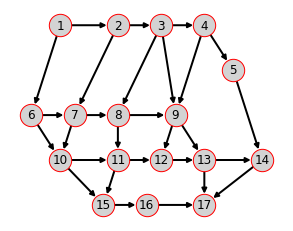

In [13]:
import scipy.io
import scipy
import cvxpy as cp

# in this section we import the .mat files and draw graph and print links.
np.set_printoptions(precision=2, suppress=True)

file = scipy.io.loadmat('D:/Courses/Semester - 3/Network_Dynamic_Learning/Homeworks Materials/capacities.mat')
capacities = file.get('capacities')
capacities = capacities.reshape(28, )

file = scipy.io.loadmat('D:/Courses/Semester - 3/Network_Dynamic_Learning/Homeworks Materials/traveltime.mat')
traveltime = file.get('traveltime')
traveltime = traveltime.reshape(28, )

file = scipy.io.loadmat('D:/Courses/Semester - 3/Network_Dynamic_Learning/Homeworks Materials/flow.mat')
flow = file.get('flow')
flow = flow.reshape(28, )

file = scipy.io.loadmat('D:/Courses/Semester - 3/Network_Dynamic_Learning/Homeworks Materials/traffic.mat')
traffic = file.get('traffic')

# creation of Graph
G = nx.DiGraph()

# connect nodes 
# compute node_edge incidence matrix
# +1 if the node is the source (tail) of an edge 
# and -1 if it is the destination (head) of the edge.
for c in range(28):            #searching in edges
    capac = capacities[c]
    travtime = traveltime[c]
    for r in range(17):        # check nodes the output edge of node i is the input node of j
        if traffic[r][c] == 1:  
            i = r              #head node
        if traffic[r][c] == -1:
            j = r              # tail node
    G.add_edges_from([(i + 1, j + 1)], capacity=capac, traveltime=travtime)
edges = G.edges()
print(edges)      

# draw Graph
fig, ax = plt.subplots(figsize=(5, 4))

pos = {1: [-3, 1], 2: [-1, 1], 3: [0.5, 1], 4: [2, 1], 5: [3, 0], 6: [-4, -1], 7: [-2.5, -1], 8: [-1, -1], 9: [1, -1],
       10: [-3, -2], 11: [-1, -2], 12: [0.5, -2], 13: [2, -2], 14: [4, -2], 15: [-1.5, -3], 16: [0, -3], 17: [2, -3]}

nx.draw(G, pos, node_size=500, font_size=12, node_color='lightgray', with_labels=True, width=2, edge_color='black',
        edgecolors='red', ax=ax)

plt.savefig("plot3.1.svg")

(a) Find the shortest path between node 1 and 17. This is equivalent to the fastest path (path
with shortest traveling time) in an empty network.

The shortest path from node 1 to node 17:  [1, 2, 3, 9, 13, 17]


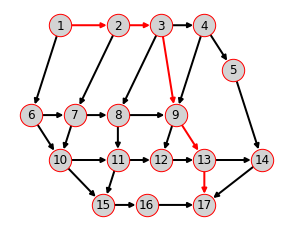

In [14]:
print("The shortest path from node 1 to node 17: ", nx.shortest_path(G, source=1, target=17, weight='traveltime'))
fig, ax = plt.subplots(figsize=(5, 4))

edge_colors = ["red", "black", "red", "black", "black", "black", "red", "black", "black", "black",
               "black", "black", "black", "black", "black", "black", "red", "black", "black", "red",
               "black", "black", "black", "black", "black", "black", "black", "black"]
nx.draw(G, pos, node_size=500, font_size=12, node_color='lightgray', with_labels=True, width=2, edge_color=edge_colors,
        edgecolors='red', ax=ax)

plt.savefig("plot3.2.svg")

(b) Find the maximum flow between node 1 and 17.

In [15]:
#maximum flow between 1 to 17:
print("Maximum flow from node 1 to 17: ", nx.algorithms.flow.maximum_flow(G, 1, 17))

Maximum flow from node 1 to 17:  (22448, {1: {2: 8741, 6: 13707}, 2: {3: 8741, 7: 0}, 3: {4: 0, 8: 0, 9: 8741}, 4: {5: 0, 9: 0}, 5: {14: 0}, 6: {7: 4624, 10: 9083}, 7: {8: 4624, 10: 0}, 8: {9: 4624, 11: 0}, 9: {13: 6297, 12: 7068}, 13: {14: 3835, 17: 10355}, 14: {17: 3835}, 10: {11: 825, 15: 8258}, 11: {12: 825, 15: 0}, 15: {16: 8258}, 12: {13: 7893}, 17: {}, 16: {17: 8258}})


**(c)** Given the flow vector in flow.mat, compute the external inflow $\nu$ satisfying Bf = $\nu$.
In the following, we assume that the exogenous inflow is zero in all the nodes except for node 1,
for which $\nu_{1}$ has the same value computed in the point (c), and node 17, for which $\nu_{17}$ = -$\nu_{1}$

In [16]:
#import cvxpy as cp
# C :external inflow 'v' satisfying Bf = v
B_matrix = traffic
n_edges = B_matrix.shape[1]

# unitary inflow from node 1 to node 17
nu = np.array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1])  # exogenous flow vector  تنظیم درجه ورودی و خروجی هر نود
l = np.array(traveltime)

# Construct the problem.
f = cp.Variable(n_edges)

# l stores the coefficients of the linear terms of the objective function, in this case the length of the links.
objective = cp.Minimize(l.T @ f)
constraints = [B_matrix @ f == nu, f >= 0]      #define limitation of the problem
prob = cp.Problem(objective, constraints)

# The optimal objective value is returned by `prob.solve()`.
cost_opt = prob.solve()

# The optimal value for f is stored in `f.value`.
print("Optimal f:", f.value)

Optimal f: [1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0.]


In [17]:
external_inflow = B_matrix @ flow
print("external_inflow:", external_inflow)

external_inflow: [ 16806   8570  19448   4957   -746   4768    413     -2  -5671   1169
     -5  -7131   -380  -7412  -7810  -3430 -23544]


**(d)** Find the social optimum $f^∗$ with respect to the delays on the different links $\tau_e$($f_e$). For this,
minimize the cost function


$$
\sum_{e\in E}f_e(\tau_e(f_e) = \sum_{e\in E} \frac {\ f_e l_e }{1 - f_e / c_e}  = \sum_{e\in E} \frac {\ l_e c_e}{1 - f_e / c_e}\, - l_e c_e
$$

In [18]:
# D: Find the social optimum f∗ and optimum cost:
# exogenous inflow vector
nu = np.array([16806, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -16806])

# Construct the problem.
f = cp.Variable(n_edges)

# cost function
func = cp.multiply(traveltime * capacities, cp.inv_pos(1 - cp.multiply(f, 1 / capacities))) - traveltime * capacities
func = cp.sum(func)

# Construct the problem.
# Minimize cost function
objective = cp.Minimize(func)
constraints = [B_matrix @ f == nu, f >= 0, f <= capacities]  # 0 ≤ fe < ce.
prob = cp.Problem(objective, constraints)

# The optimal objective value is returned by `prob.solve()`.
cost_opt = prob.solve()

# The optimal value for f is stored in `f.value`.
opt_flow = f.value
print("Social optimal flow:", opt_flow)
print("Optimal cost:", cost_opt)

Social optimal flow: [ 6642.2   6058.94  3132.33  3132.33 10163.8   4638.32  3006.34  2542.63
  3131.54   583.26     0.01  2926.6      0.    3132.33  5525.48  2854.27
  4886.45  2215.24   463.72  2337.69  3317.99  5655.68  2373.11     0.
  6414.12  5505.43  4886.45  4886.45]
Optimal cost: 25943.62261121288


**(e)** Find the Wardrop equilibrium $f^0$. For this, use the cost function

$$
 \sum_{e \in \mathcal{E}}\int_0^{f_e} \tau_e(s)~\mathrm{d}s.
$$


In [19]:
# E1: Find the Wardrop equilibrium
f = cp.Variable(n_edges)

# cost function
integral = - cp.multiply(traveltime * capacities, cp.log(1 - (cp.multiply(f, 1 / capacities))))
func2 = cp.sum(integral)

# minimize cost function
objective = cp.Minimize(func2)
constraints = [B_matrix @ f == nu, f >= 0, f <= capacities]
prob = cp.Problem(objective, constraints)

cost_w = prob.solve()

print("Wardrop equilibrium flow:", f.value)

Wardrop equilibrium flow: [ 6715.65  6715.65  2367.41  2367.41 10090.35  4645.39  2803.84  2283.56
  3418.48     0.     176.83  4171.41     0.    2367.41  5444.96  2353.17
  4933.34  1841.55   697.11  3036.49  3050.28  6086.77  2586.51     0.
  6918.74  4953.92  4933.34  4933.34]


**(e)** Introduce tolls, such that the toll on link e is
$\omega_e$ = $f_e^\;*$  $\tau_e^\prime$ $(f_e^\;* $)
where $f_e^\;*$ is the flow at the system optimum. Now the delay on link e is given by
$\tau_e$($f_e$)+ $\omega_e$. 
compute the new Wardrop equilibrium $f^{(\omega)}$ . What do you observe?

In [20]:
#E2: wardrop cost and computing new wardrop:

war_vect = f.value

print("Wardrop equilibrium without tolls:", war_vect)

# cost, defined as \sum_e f_e d_e(f_e)
def cost(f):
    tot = []
    for i, value in enumerate(f):
        tot.append(((traveltime[i] * capacities[i]) / (1 - (value / capacities[i]))) - traveltime[i] * capacities[i])
    return sum(tot)

cost_w = cost(war_vect) # evaluate the social cost at the Wardrop equilibrium

print("Wardrop cost:", cost_w)

PoA = cost_w / cost_opt
print("The cost without tolls:", cost_w)
print("The Optimal cost without tolls:", cost_opt)
print("--------------------------------------------------------")
print("The price of anarchy:", PoA)  #POA: the ratio between the Wardrop cost and the optimal cost.

f = cp.Variable(n_edges)

# compute omega
omega = []
for i, value in enumerate(opt_flow):
    omega.append(value * ((capacities[i] * traveltime[i]) / ((capacities[i] - value) ** 2)))

func3 = cp.sum(
    cp.multiply(omega, f) - cp.multiply(capacities * traveltime, cp.log(1 - (cp.multiply(f, 1 / capacities)))))

objective = cp.Minimize(func3)
constraints = [B_matrix @ f == nu, f >= 0, f <= capacities]
prob = cp.Problem(objective, constraints)

result = prob.solve()
print("--------------------------------------------------------")
print("Wardrop equilibrium with tolls:", f.value)
print("--------------------------------------------------------")

war_vect = f.value
# compute cost of wardrop equilibrium
cost_w = cost(war_vect)

print("Wardrop cost w:", cost_w)

PoA = cost_w / cost_opt
print("The cost with tolls:", cost_w)
print("The Optimal cost with tolls:", cost_opt)
print("--------------------------------------------------------")
print("The price of anarchy w:", PoA)

Wardrop equilibrium without tolls: [ 6715.65  6715.65  2367.41  2367.41 10090.35  4645.39  2803.84  2283.56
  3418.48     0.     176.83  4171.41     0.    2367.41  5444.96  2353.17
  4933.34  1841.55   697.11  3036.49  3050.28  6086.77  2586.51     0.
  6918.74  4953.92  4933.34  4933.34]
Wardrop cost: 26292.963874629393
The cost without tolls: 26292.963874629393
The Optimal cost without tolls: 25943.62261121288
--------------------------------------------------------
The price of anarchy: 1.013465400289377
--------------------------------------------------------
Wardrop equilibrium with tolls: [ 6642.97  6059.08  3132.47  3132.47 10163.03  4638.26  3006.33  2542.34
  3131.49   583.9      0.    2926.6      0.    3132.47  5524.77  2854.23
  4886.37  2215.83   463.99  2337.45  3318.22  5655.67  2373.04     0.
  6414.12  5505.51  4886.37  4886.37]
--------------------------------------------------------
Wardrop cost w: 25943.62261534188
The cost with tolls: 25943.62261534188
The Optimal c

**(f)** Instead of the total travel time, let the cost for the system be the total additional delay
compared to the total delay in free flow, given by $ψ_e(f_e) = f_e(τ_e(f_e) − l_e)$ 

subject to the flow constraints. Compute the system optimum $f^{\;*}$ for the costs above. Construct tolls ω∗such that the Wardrop equilibrium $f^{(\omega^\;*)}$ coincides with $f^{\;*}$. Compute the new Wardrop equilibrium with the constructed tolls $f^{(\omega^\;*)}$ to verify your result.

In [21]:
# F: Compute the system optimum f*, Optimal cost,Constructed tolls,Wardrop equilibrium,Wardrop cost,The price of anarchy:

f = cp.Variable(n_edges)

# cost function free flow delay
func4 = cp.sum(
    cp.multiply(cp.multiply(traveltime, capacities), cp.inv_pos(1 - cp.multiply(f, 1 / capacities))) - cp.multiply(
        traveltime, capacities) - cp.multiply(traveltime, f))

objective = cp.Minimize(func4)
constraints = [B_matrix @ f == nu, f >= 0, f <= capacities]
prob = cp.Problem(objective, constraints)

# The optimal objective value is returned by `prob.solve()`.
cost_opt = prob.solve()

# The optimal value for f is stored in `f.value`.
opt_flow = f.value
print("Social optimal flow:", opt_flow)
print("Optimal cost:", cost_opt)
w = cp.Variable(n_edges)

nu = np.array([16806, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -16806])

# cost function with optimal flow
integral = - cp.multiply(capacities * traveltime, cp.log(1 - (cp.multiply(opt_flow, 1 / capacities)))) - cp.multiply(
    opt_flow, traveltime) + cp.multiply(w, opt_flow)
func5 = cp.sum(integral)

objective = cp.Minimize(func5)
constraints = [B_matrix @ w == nu, w >= 0]
prob = cp.Problem(objective, constraints)

result_w = prob.solve()

print("Constructed tolls:", w.value)
constr_tolls = w.value

f_new = cp.Variable(n_edges)
nu = np.array([16806, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -16806])

#-------------------------------------------------
func = - cp.multiply(capacities * traveltime, cp.log(1 - (cp.multiply(f_new, 1 / capacities)))) 
- cp.multiply(f_new,traveltime) + cp.multiply(constr_tolls, f_new)

objective = cp.Minimize(cp.sum(func))
constraints = [B_matrix @ f_new == nu, f_new >= 0, f_new <= c, f_new == opt_flow]
prob = cp.Problem(objective, constraints)

result_w = prob.solve()

print("Wardrop equilibrium:", f_new.value)


if f_new.value is not None:
    def cost2(f):
        tot = []
        for i, value in enumerate(f):
            tot.append(((l[i] * c[i]) / (1 - (value / c[i]))) - l[i] * c[i] - l[i] * value)
        return sum(tot)
    

    war_vect = f_new.value
    cost_w = cost2(war_vect)

    print("Wardrop cost:", cost_w)

    PoA = cost_w / cost_opt

    print("The price of anarchy:", PoA)

Social optimal flow: [ 6653.3   5774.66  3419.72  3419.71 10152.7   4642.78  3105.84  2662.18
  3009.08   878.63     0.01  2354.94     0.01  3419.71  5509.92  3043.69
  4881.81  2415.57   443.66  2008.05  3487.35  5495.4   2203.78     0.
  6300.7   5623.49  4881.81  4881.81]
Optimal cost: 15095.51352460787
Constructed tolls: [16806.     0.     0.     0.     0.     0. 16806.     0.     0. 16806.
     0.     0.     0.     0.     0.     0.     0.     0. 16806.     0.
     0.     0.     0. 16806.     0.     0. 16806. 16806.]
Wardrop equilibrium: None
